In [1]:
import pandas as pd
data = pd.read_csv('/workspaces/codespaces-jupyter/data/data alat kandang.csv')
print(data)

     Suhu  Kelembaban      NH3   Kipas_1   Kipas_2
0    32.8        55.2  0.06025  33.32859  33.32859
1    32.8        55.9  0.06466  33.59708  33.59708
2    32.9        54.8  0.06816  33.17909  33.17909
3    32.8        55.2  0.07437  33.32859  33.32859
4    32.9        55.7  0.06581  33.51903  33.51903
..    ...         ...      ...       ...       ...
145  33.6        48.2  0.04435  30.78049  30.78049
146  33.6        48.7  0.04771  30.95363  30.95363
147  33.5        49.0  0.04354  31.05811  31.05811
148  33.5        49.5  0.04771  31.23454  31.23454
149  33.6        48.7  0.04354  30.95363  30.95363

[150 rows x 5 columns]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2023-03-16 10:23:55.270548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 10:23:55.389557: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-16 10:23:55.389583: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-16 10:23:56.170793: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

Splitting data for input and output

In [3]:
X = data[['Suhu', 'Kelembaban', 'NH3']].values
y = data[['Kipas_1', 'Kipas_2']].values

Scalling the data

In [4]:
sc_X = MinMaxScaler()
sc_y = MinMaxScaler(feature_range=(0, 1))
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

Splitting data for training and test

In [13]:
train_size = int(len(data) * 0.7)
test_size = len(data) - train_size
X_train, X_test = X[0:train_size,:], X[train_size:len(data),:]
y_train, y_test = y[0:train_size,:], y[train_size:len(data),:]

Reshape the input to 3D [samples, timestep, features]

In [14]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

Make the LSTM Model

In [7]:
model = Sequential([
    LSTM(16, input_shape=(1, 3), return_sequences=True),
    Dropout(0.2),
    LSTM(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.2),
    Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.2),
    Dense(2, activation='linear', kernel_regularizer=regularizers.l2(0.001))
])

adam = Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=adam)

early_stop = EarlyStopping(monitor='val_loss', patience=10)

model.summary()

2023-03-16 10:23:57.474288: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-16 10:23:57.474322: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-16 10:23:57.474345: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (codespaces-e8dfb7): /proc/driver/nvidia/version does not exist
2023-03-16 10:23:57.474599: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 16)             1280      
                                                                 
 dropout (Dropout)           (None, 1, 16)             0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 800       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 4)                 36        
                                                                 
 dropout_2 (Dropout)         (None, 4)                 0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1

Train the Model

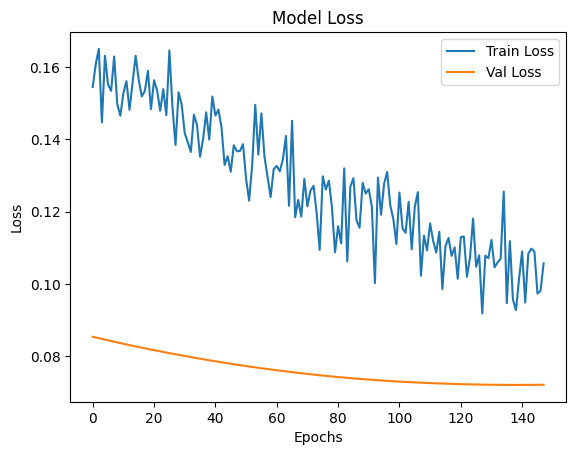

In [15]:
history = model.fit(X_train, y_train, epochs=1000, batch_size=64, validation_data=(X_test, y_test), verbose=0, callbacks=[early_stop])

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Make the prediction, and invert scaling

In [16]:
y_train_pred = sc_y.inverse_transform(model.predict(X_train))
y_train_actual = sc_y.inverse_transform(y_train)
y_test_pred = sc_y.inverse_transform(model.predict(X_test))
y_test_actual = sc_y.inverse_transform(y_test)


2/2 [==============================] - 0s 3ms/step


Make the input

In [17]:
def get_user_input():
    suhu = float(input('Masukkan suhu: '))
    kelembapan = float(input('Masukkan kelembapan: '))
    nh3 = float(input('Masukkan NH3: '))
    return np.array([[suhu, kelembapan, nh3]])

input_data = get_user_input()

input_data = sc_X.transform(input_data)

input_data = np.reshape(input_data, (1, 1, 3))

Predict the output

In [18]:
output = model.predict(input_data)

output = sc_y.inverse_transform(output)

print('Prediction of fan speed 1: ', output[0][0])
print('Prediction of fan speed 1: ', output[0][1])

1/1 [==============================] - 0s 31ms/step
Prediction of fan speed 1:  34.0609
Prediction of fan speed 1:  34.73332


Ploting the actual speed and the prediction speed

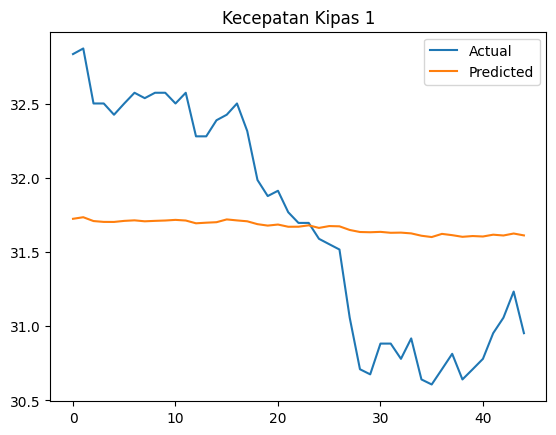

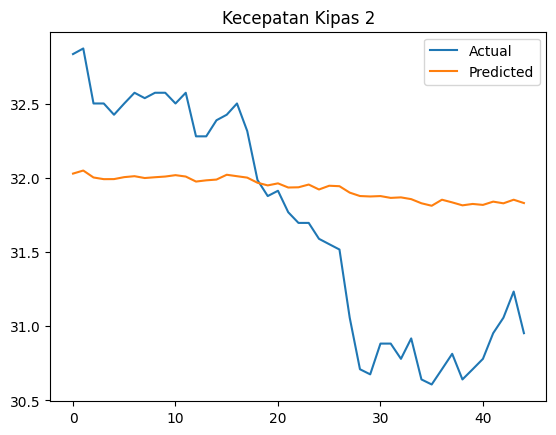

In [19]:
plt.plot(y_test_actual[:,0], label='Actual')
plt.plot(y_test_pred[:,0], label='Predicted')
plt.title('Kecepatan Kipas 1')
plt.legend()
plt.show()

plt.plot(y_test_actual[:,1], label='Actual')
plt.plot(y_test_pred[:,1], label='Predicted')
plt.title('Kecepatan Kipas 2')
plt.legend()
plt.show()